In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [16]:
from astropy.table import Table
from exoplanet.gp import terms, GP
import exoplanet as xo
from kde_contour import kdeplot_2d_clevels
import pandas as pd
import pymc3 as pm
import scipy.stats as ss
import seaborn as sns
import theano
import theano.tensor as tt
from tqdm import tqdm
import warnings

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

In [3]:
visit = Table.read('../apogee/allVisit-v603.fits').to_pandas()
stars = Table.read('../apogee/allStar-v603.fits', hdu=1)

names = [name for name in stars.colnames if len(stars[name].shape) <= 1]
stars = stars[names].to_pandas()

In [4]:
joint = pd.merge(visit, stars, on='APOGEE_ID')
joint.sort_values(['APOGEE_ID', 'JD']);

In [5]:
rgs = joint[(joint['LOGG'] < 2) & (joint['LOGG'] > -1000)]

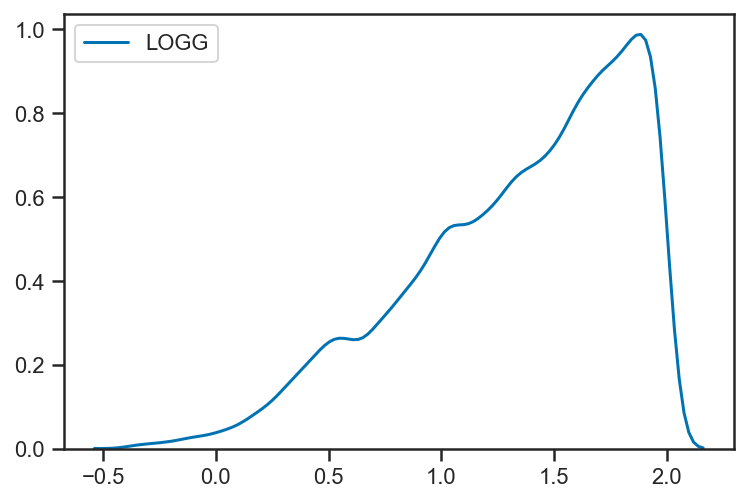

In [6]:
sns.kdeplot(rgs['LOGG'])

In [7]:
def count_num_5d(ts):
    dt = diff(sort(ts))
    
    return count_nonzero((dt < 5) & (dt > 0))

by_aid = rgs.groupby('APOGEE_ID')
num_5d_visits = by_aid.agg({'JD': count_num_5d})

In [8]:
i = 1
aid = num_5d_visits.sort_values(by='JD', ascending=False).index[i]
d = by_aid.get_group(aid)
d.sort_values(by='JD');

b'2M19480168+2349089' has log(g) = 1.39


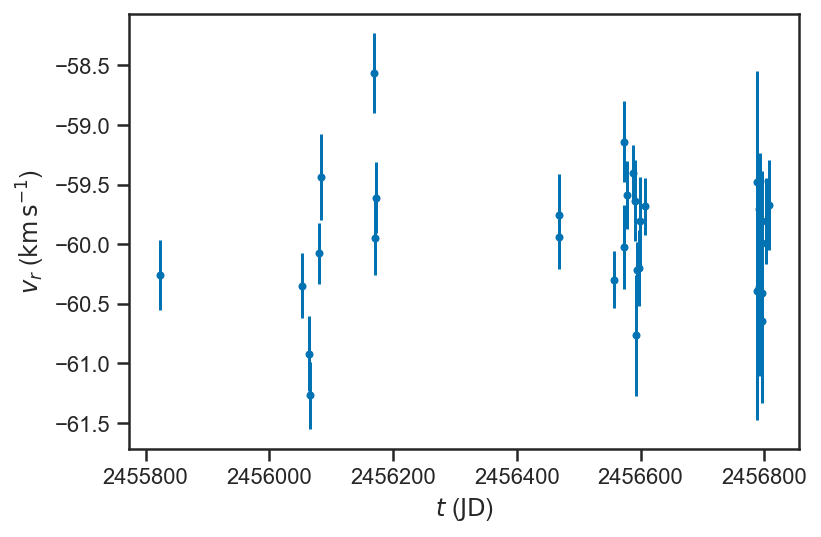

In [9]:
errorbar(d['JD'], d['VHELIO'], d['VRELERR'], fmt='.')

xlabel(r"$t$ ($\mathrm{JD}$)")
ylabel(r"$v_r$ ($\mathrm{km} \, \mathrm{s}^{-1}$)")

print('{:s} has log(g) = {:.2f}'.format(str(d['APOGEE_ID'].iloc[0]), d['LOGG'].iloc[0]))

These formulas come from [Kallinger, et al. (2014)](http://dx.doi.org/10.1051/0004-6361/201424313) and [Cohelo, et al. (2015)](http://dx.doi.org/10.1093/mnras/stv1175); particularly the latter is only calibrated against sub-giants, so who knows....

In [10]:
teff_solar = 5777.0
logg_solar = 4.4374

numax_solar = 3090.0*1e-6*3600.0*24.0
nugran_solar = 30*1e-6*3600.0*24.0

numax_est = numax_solar*10**(d['LOGG']-logg_solar)*sqrt(d['TEFF']/teff_solar)
nugran_est = nugran_solar * (numax_est/numax_solar)**0.89

numax_est = numax_est.iloc[0]
nugran_est = nugran_est.iloc[0]

print('Estimated nu_max = {:.2g} / d, nu_gran = {:.2g} / d'.format(numax_est, nugran_est))

Estimated nu_max = 0.21 / d, nu_gran = 0.0044 / d


In [11]:
m = mean(d['VHELIO'])
s = std(d['VHELIO'])

d = d.sort_values(by='JD', ascending=True)
d = d[~(isnan(d['JD'])) & ~(isnan(d['VHELIO'])) & ~(isnan(d['VRELERR']))]

w0_est = 2*pi*numax_est
S0_est = s*s / (w0_est*2)

wgran_est = 2*pi*nugran_est
Sgran_est = s*s/(wgran_est/sqrt(2))

with pm.Model() as model:
    mu = pm.Normal('mu', mu=m, sigma=10*s, testval=m)
    
    log_Sgran = pm.Normal('log_Sgran', mu=log(Sgran_est), sigma=2.0*log(3), testval=log(Sgran_est))
    log_wgran = pm.Normal('log_wgran', mu=log(wgran_est), sigma=log(3), testval=log(wgran_est))
    Qgran = 1/sqrt(2)
    
    log_S0 = pm.Normal('log_S0', mu=log(S0_est), sigma=2.0*log(3), testval=log(S0_est))
    log_w0 = pm.Normal('log_w0', mu=log(w0_est), sigma=log(3), testval=log(w0_est))
    log_Q = pm.Bound(pm.Normal, lower=0.5)('log_Q', mu=log(2), sigma=log(3), testval=log(2))
    
    var_gran = pm.Deterministic('var_gran', tt.exp(log_Sgran + log_wgran + log(Qgran)))
    var_SHO = pm.Deterministic('var_SHO', tt.exp(log_S0 + log_w0 + log_Q))
    _ = pm.Deterministic('var', var_gran+var_SHO)
    _ = pm.Deterministic('wgran', tt.exp(log_wgran))
    _ = pm.Deterministic('w0', tt.exp(log_w0))
    _ = pm.Deterministic('Q', tt.exp(log_Q))
    
    kernel = terms.SHOTerm(log_S0=log_Sgran, log_w0=log_wgran, Q=Qgran)
    kernel += terms.SHOTerm(log_S0=log_S0, log_w0=log_w0, log_Q=log_Q)
    gp = GP(kernel, d['JD'].to_numpy(), (d['VRELERR']*d['VRELERR']).to_numpy().astype(np.float64), mean=mu, J=4)
    
    gp.marginal('gp', observed=d['VHELIO'].to_numpy().astype(np.float64))

In [41]:
with model:
    trace = pm.sample(tune=2000, draws=2000, cores=4, chains=4, step=xo.get_dense_nuts_step())

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_Q, log_w0, log_S0, log_wgran, log_Sgran, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [02:58<00:00, 89.75draws/s] 
The number of effective samples is smaller than 25% for some parameters.


In [42]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,-59.927,0.207,-60.300,-59.576,0.005,0.003,1784.0,1784.0,2483.0,2228.0,1.00
log_Sgran,1.097,1.573,-1.921,4.123,0.037,0.026,1824.0,1824.0,1874.0,2408.0,1.00
log_wgran,-3.705,1.144,-5.884,-1.720,0.026,0.019,1883.0,1849.0,1916.0,2747.0,1.00
log_S0,-3.008,1.164,-5.359,-1.007,0.035,0.026,1135.0,998.0,1297.0,1629.0,1.00
log_w0,-0.402,0.758,-1.909,1.316,0.027,0.019,802.0,802.0,1175.0,998.0,1.01
log_Q,1.351,0.628,0.500,2.437,0.016,0.012,1632.0,1345.0,1570.0,1812.0,1.01
var_gran,0.139,0.217,0.000,0.457,0.005,0.004,1641.0,1641.0,1151.0,2098.0,1.00
var_SHO,0.163,0.106,0.000,0.345,0.002,0.001,3067.0,3067.0,2015.0,1486.0,1.00
var,0.303,0.220,0.067,0.626,0.005,0.003,2140.0,1988.0,2858.0,3126.0,1.00
wgran,0.045,0.058,0.000,0.135,0.001,0.001,3134.0,3134.0,1916.0,2747.0,1.00


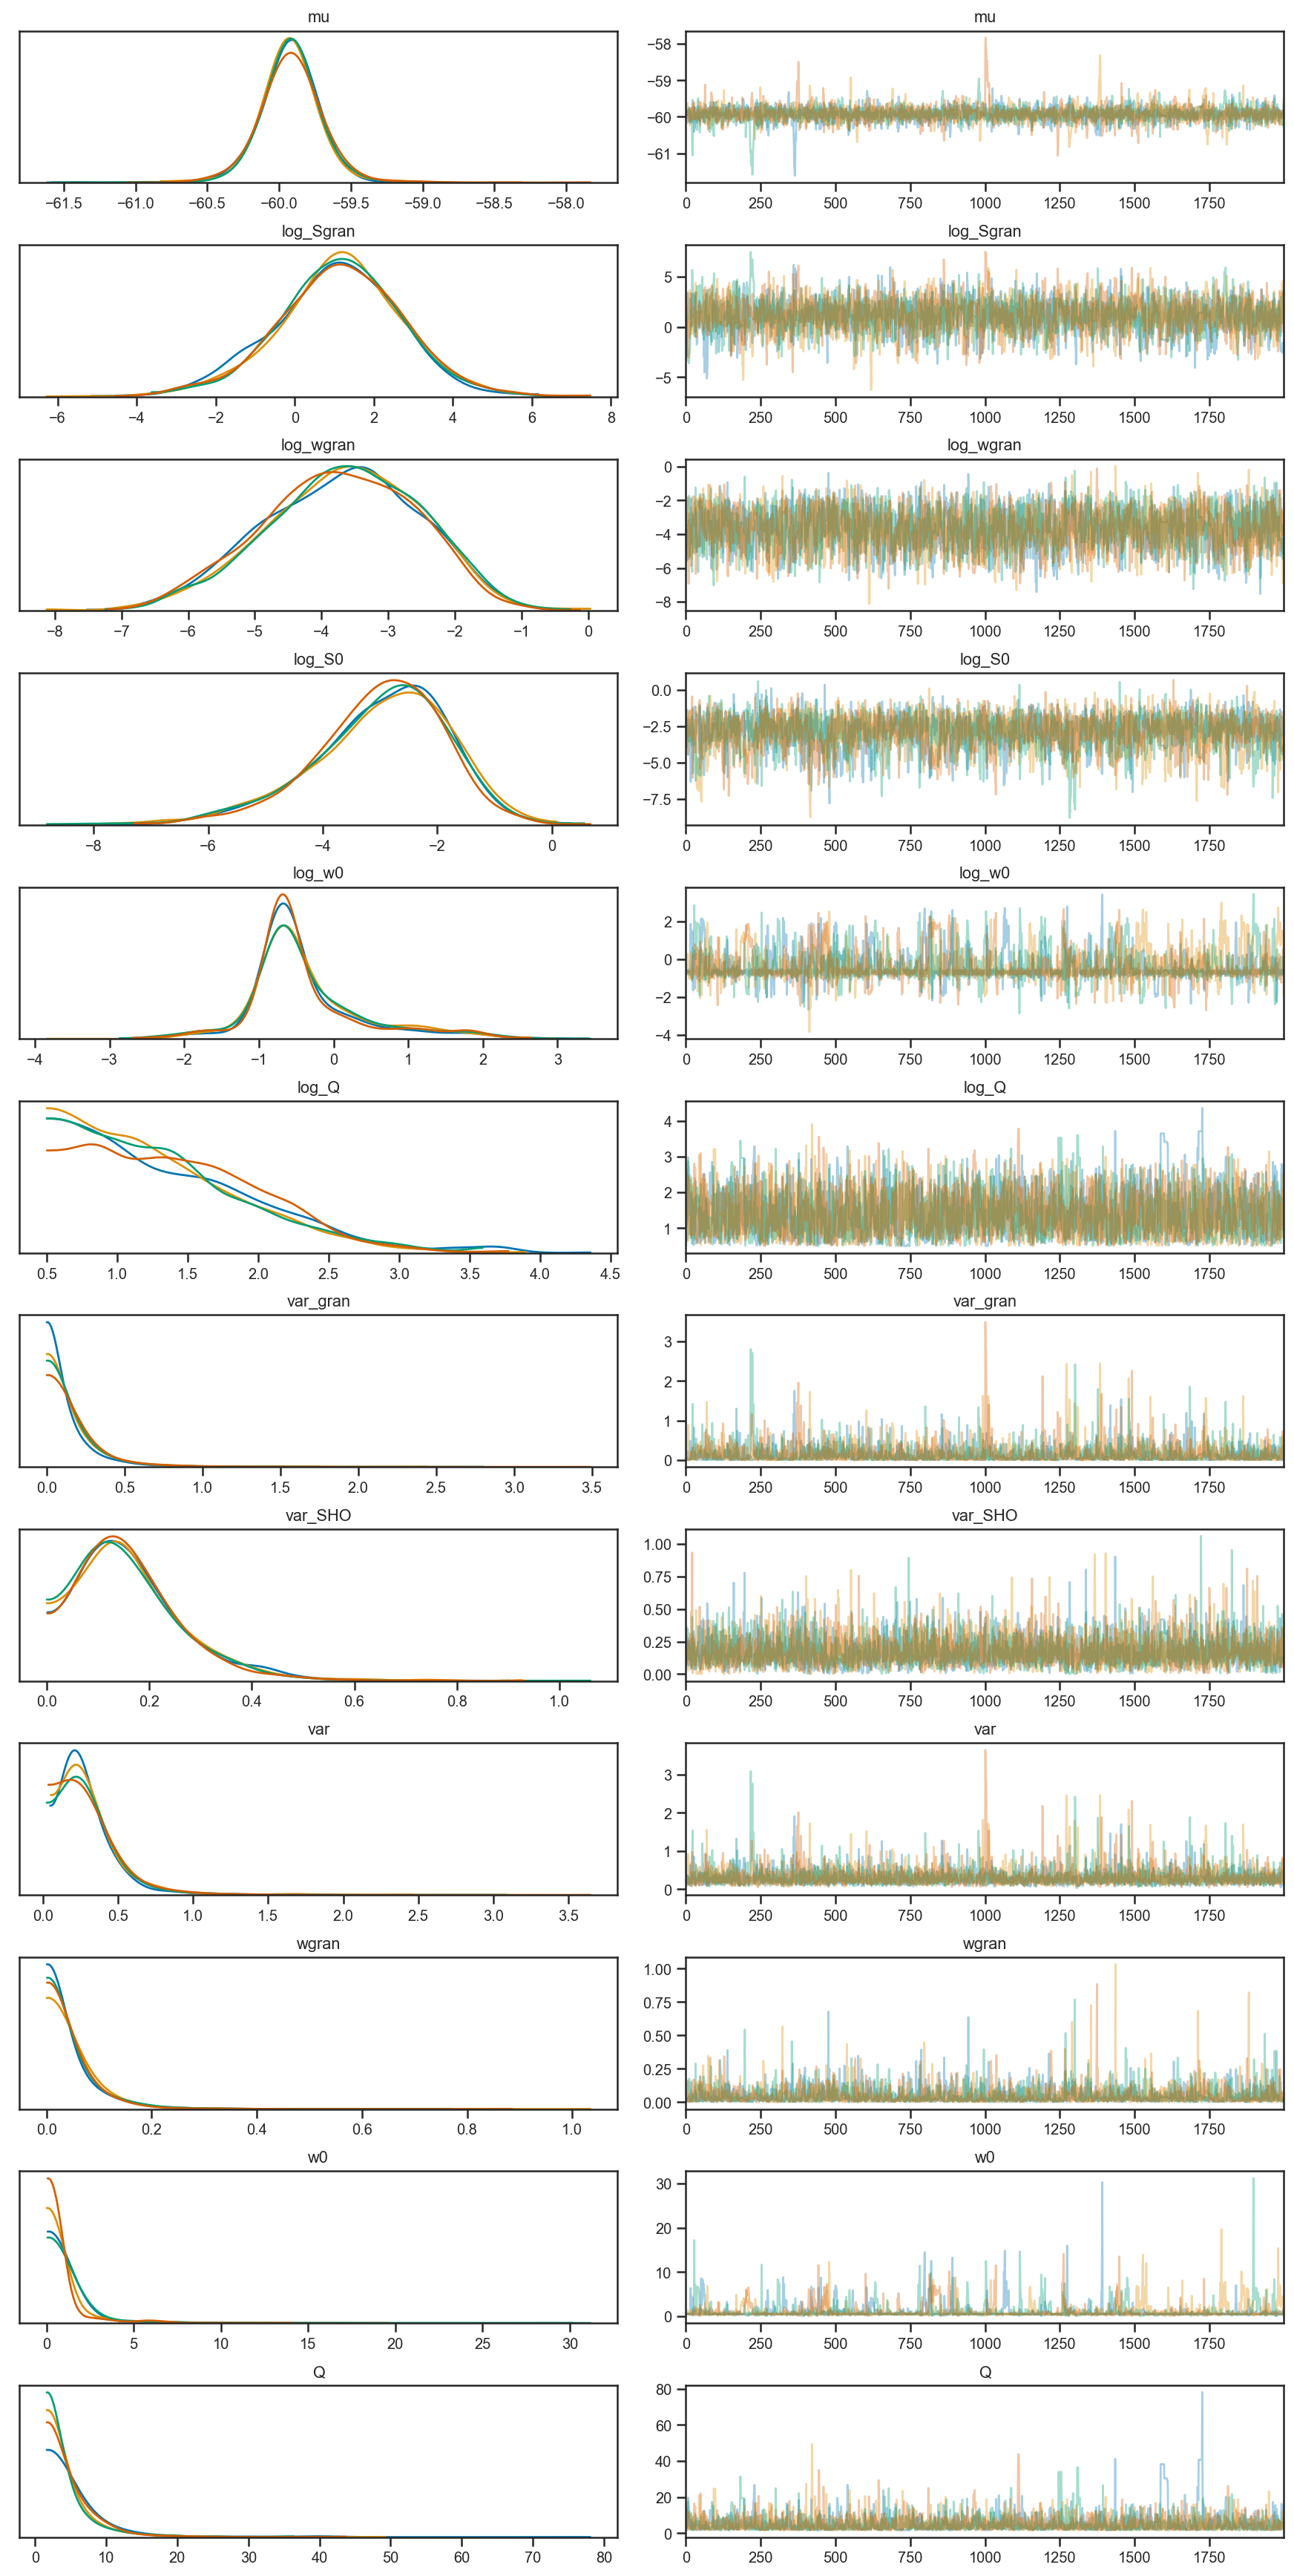

In [43]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    pm.plot_trace(trace)

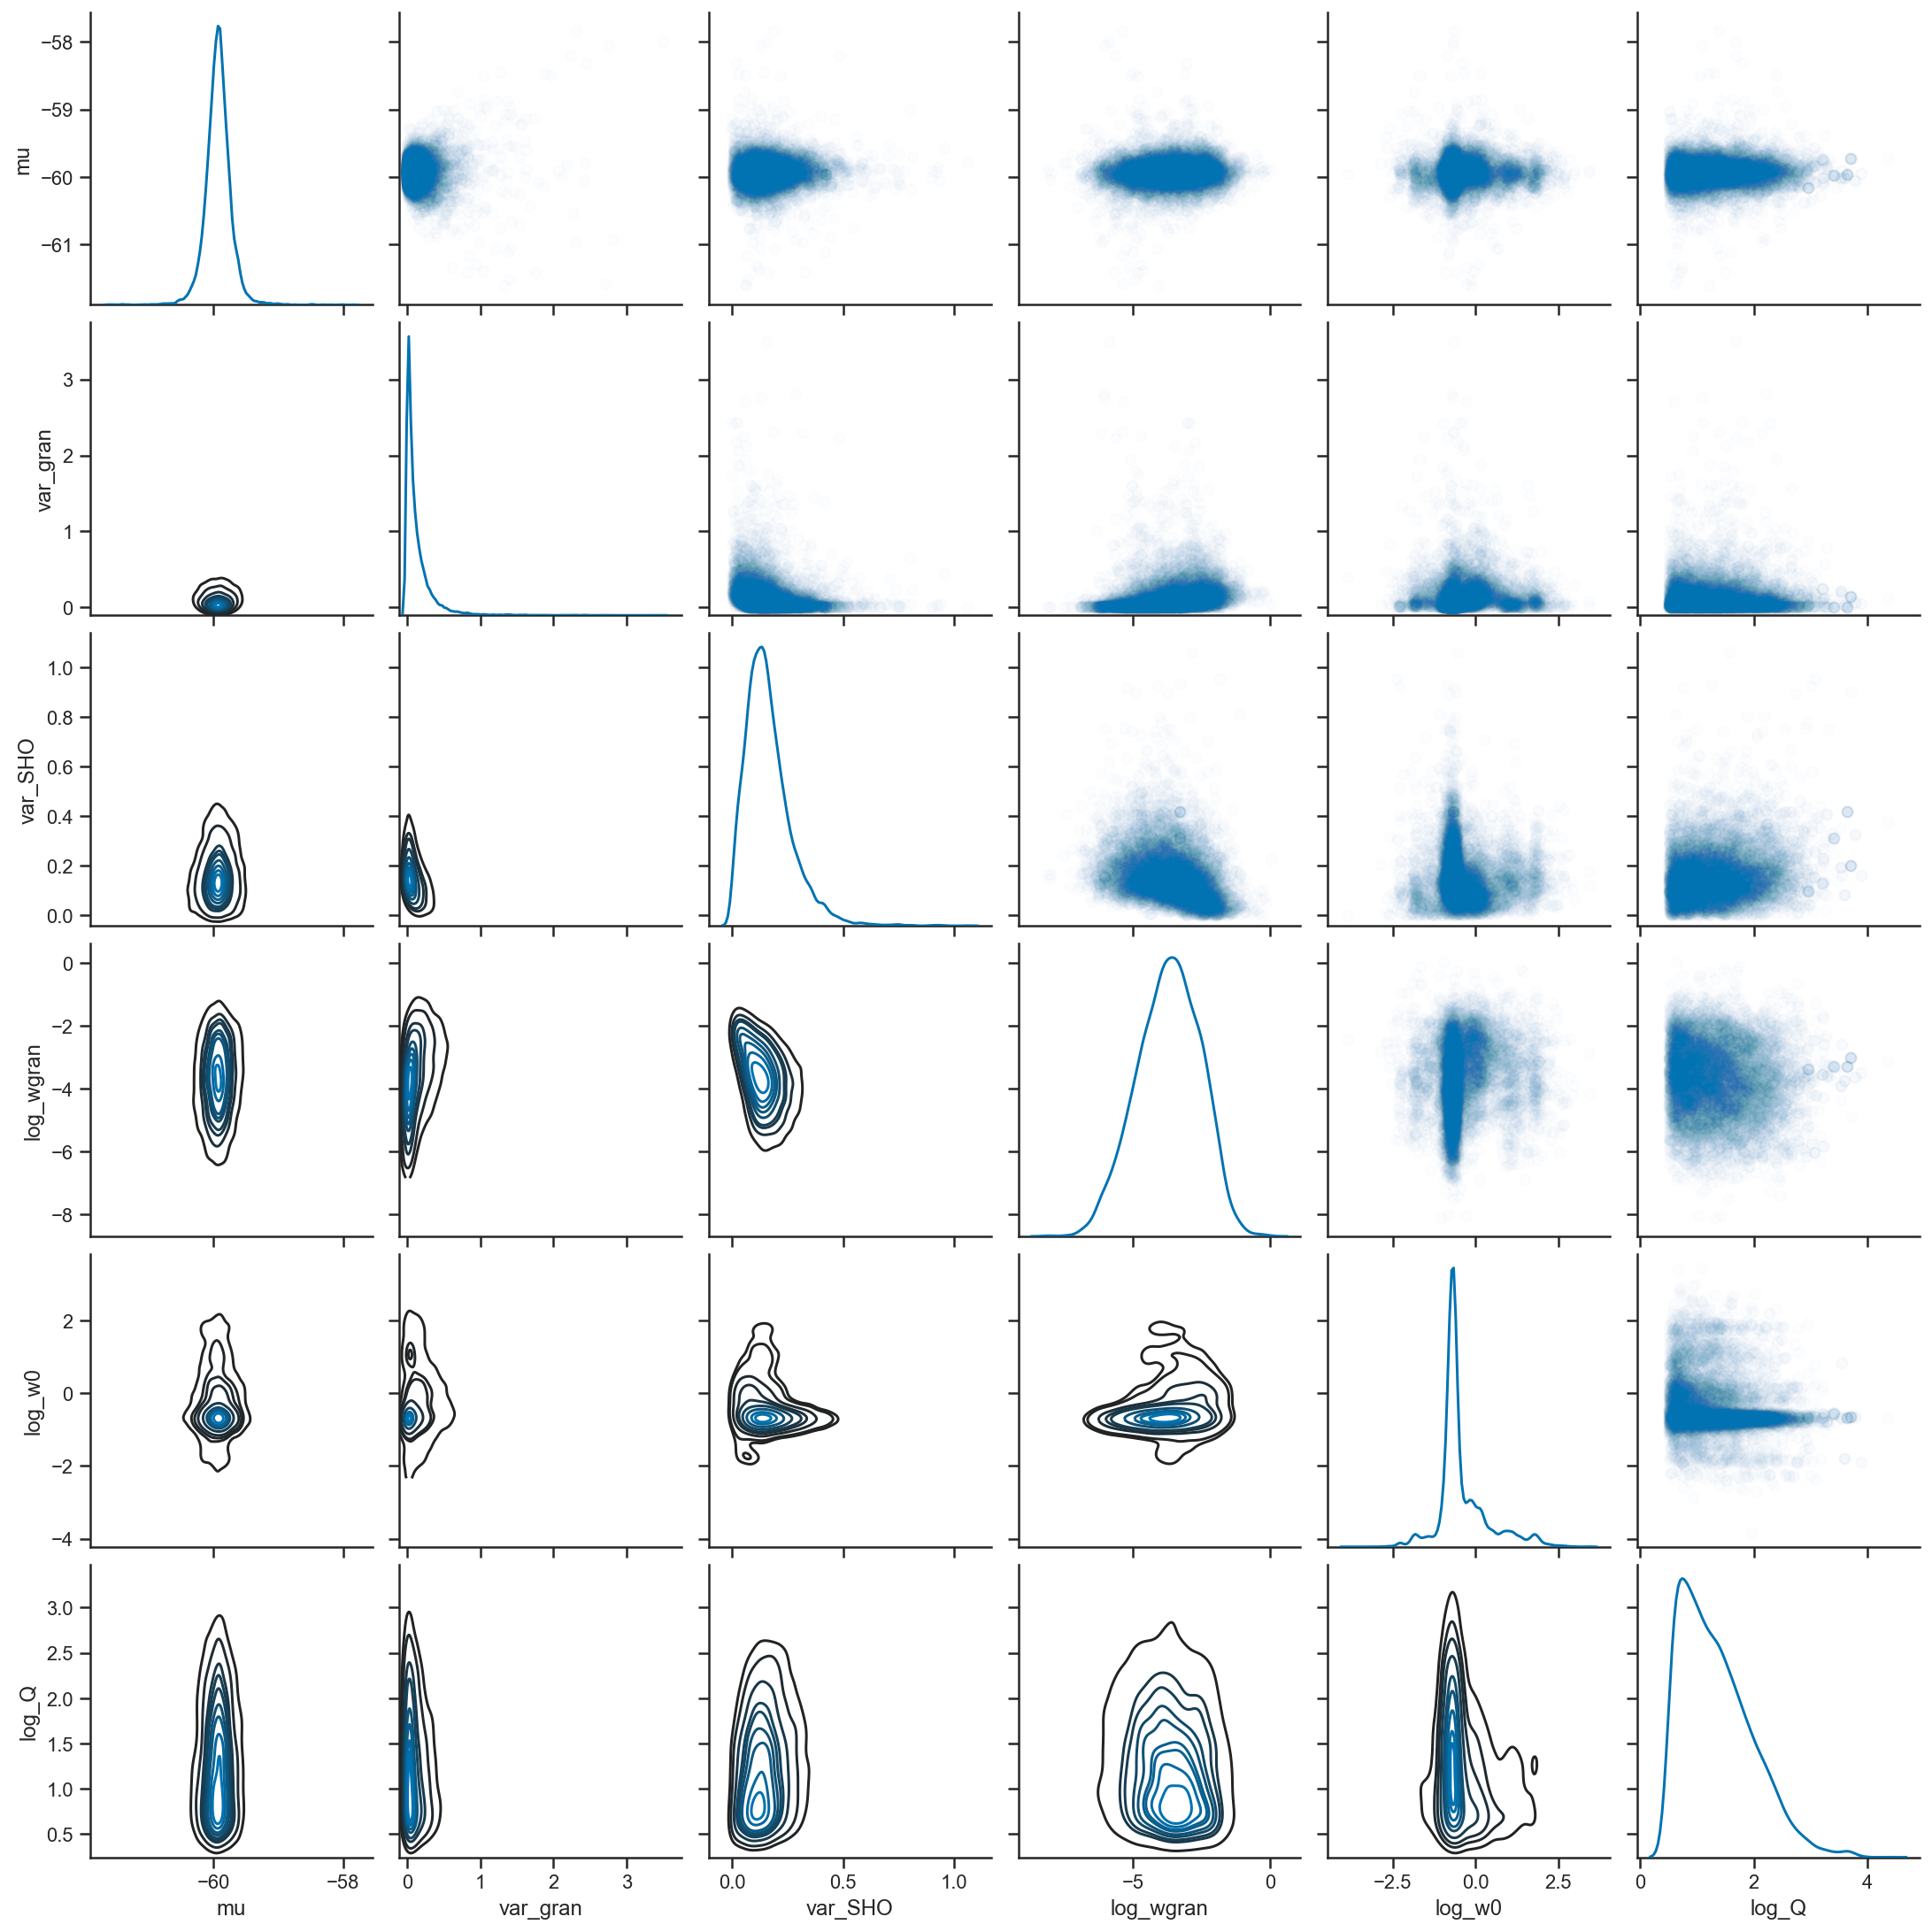

In [44]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df = pm.trace_to_dataframe(trace)
    g = sns.PairGrid(df, diag_sharey=False, vars=['mu', 'var_gran', 'var_SHO', 'log_wgran', 'log_w0', 'log_Q'])

    g.map_diag(sns.kdeplot)
    g.map_upper(scatter, alpha=0.01)
    g.map_lower(kdeplot_2d_clevels)

In [45]:
Nt = 1024
tpred = linspace(d['JD'].min(), d['JD'].max(), Nt)

In [46]:
Np = 50
pred_mu = empty((Np, Nt))
pred_var = empty((Np, Nt))
with model:
    pred = gp.predict(tpred, return_var=True)
    for i, sample in enumerate(xo.get_samples_from_trace(trace, size=Np)):
        pred_mu[i], pred_var[i] = xo.eval_in_model(pred, sample)

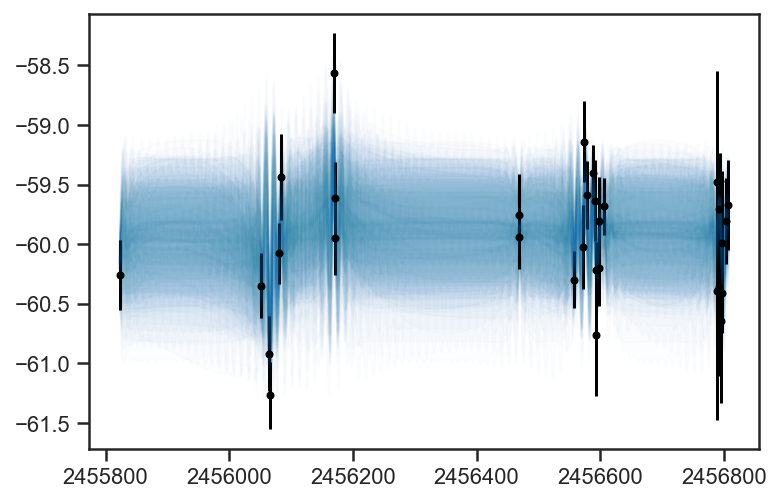

In [47]:
errorbar(d['JD'], d['VHELIO'], d['VRELERR'], fmt='.', color='k')
for i in range(Np):
    plot(tpred, pred_mu[i], color=sns.color_palette()[0], alpha=0.02)
    fill_between(tpred, pred_mu[i]+sqrt(pred_var[i]), pred_mu[i]-sqrt(pred_var[i]), color=sns.color_palette()[0], alpha=0.01)

(2456450, 2456650, -61.71556307822466, -58.066128025949)

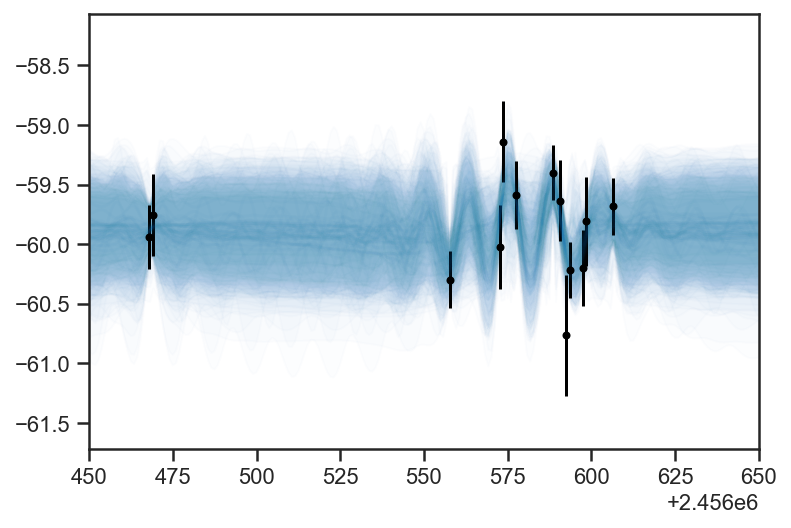

In [48]:
errorbar(d['JD'], d['VHELIO'], d['VRELERR'], fmt='.', color='k')
for i in range(Np):
    plot(tpred, pred_mu[i], color=sns.color_palette()[0], alpha=0.02)
    fill_between(tpred, pred_mu[i]+sqrt(pred_var[i]), pred_mu[i]-sqrt(pred_var[i]), color=sns.color_palette()[0], alpha=0.01)
axis(xmin=2456450, xmax=2456650)

In [49]:
No = 1024
omegas = logspace(log10(nugran_est/100.0), log10(numax_est*100.0), No)
psd = empty((Np, No))
with model:
    p = kernel.psd(omegas)
    for i, sample in enumerate(xo.get_samples_from_trace(trace, size=Np)):
        psd[i] = xo.eval_in_model(p, sample)

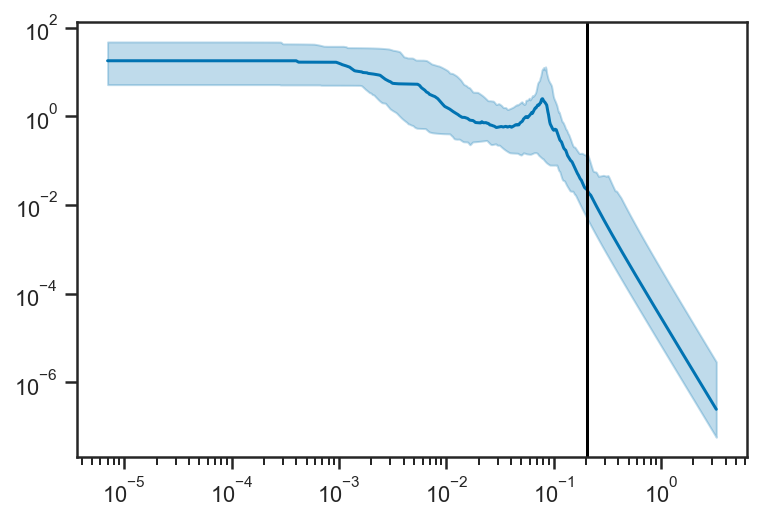

In [50]:
loglog(omegas/(2*pi), 2*pi*median(psd, axis=0))
fill_between(omegas/(2*pi), 2*pi*percentile(psd, 84, axis=0), 2*pi*percentile(psd, 16, axis=0), color=sns.color_palette()[0], alpha=0.25)
axvline(numax_est, color='k')

numax from fit = 0.98 + 1.2 - 0.18 muHz (compare to estimated 2.4 muHz)


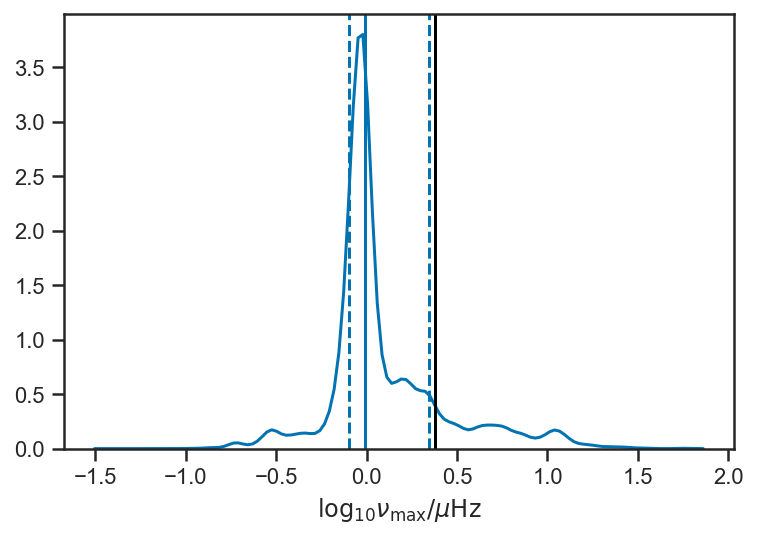

In [51]:
nu0s = exp(trace['log_w0'])/(2*pi)
m = median(nu0s)
h = percentile(nu0s, 84)
l = percentile(nu0s, 16)

per_day_to_muHz = 1e6/(3600.0*24.0)

sns.kdeplot(log10(nu0s*per_day_to_muHz))

xlabel(r'$\log_{10} \nu_\mathrm{max} / \mu\mathrm{Hz}$')

axvline(log10(m*per_day_to_muHz), color=sns.color_palette()[0])
axvline(log10(l*per_day_to_muHz), color=sns.color_palette()[0], ls='--')
axvline(log10(h*per_day_to_muHz), color=sns.color_palette()[0], ls='--')
axvline(log10(numax_est*per_day_to_muHz), color='k')

print('numax from fit = {:.2g} + {:.2g} - {:.2g} muHz (compare to estimated {:.2g} muHz)'.format(m*per_day_to_muHz, (h-m)*per_day_to_muHz, (m-l)*per_day_to_muHz, numax_est*per_day_to_muHz))